# Deep Learning

## Aufgabem
1. _Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)._
2. _Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe._
3. _Implementieren Sie Ihr Netzwerk in Keras/Tensorflow._
4. _Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._
5. _Evaluieren Sie Ihr ML-System und stellen Sie die Ergebnisse in geeigneter Weise dar. Nutzen Sie
zur Evaluation eine Kreuzvalidierung (3-fold)._
6. _In dem Notebook `transfer_learning.ipynb`_

### Laden der Daten und Splitting in Trainings- und Testdaten (Verhältnis 75:25)
Dieser Schritt ist identisch bei _Merkmalsbasierte Klassifikation_ und _Deep Learning_ und wurde somit in `setup.py` ausgelagert.
Dort wird das Verhältnis durch `split=['train[75%:]', 'test[:25%]']` erstellt.


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os
from pathlib import Path
import sys

notebook_dir = Path().resolve()
sys.path.append(str(notebook_dir.parent))

from setup import setup_dataset

train_dataset, test_dataset, metadata = setup_dataset('../dataset')

verification_image_dir = '../dataset/verification'
model_folder = 'models/'
model_filename = 'dog_classifier.h5'
weights_filename = 'model.weights.h5'

### Überlegen Sie sich eine geeignete Netzwerkarchitektur für die Klassifikationsaufgabe.
### Implementieren Sie Ihr Netzwerk in Keras/Tensorflow.
### Wahlen Sie eine geeignete Loss-Funktion und einen geeigneten Optimizer. Begründen Sie Ihre
Auswahl in Ihrem Kurzreport._

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.3835 - loss: 1.0740 - val_accuracy: 0.6400 - val_loss: 1.3760
Epoch 2/15


2024-12-10 11:08:06.046788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:06.046812: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.6716 - loss: 0.8697 - val_accuracy: 0.3600 - val_loss: 0.9462
Epoch 3/15


2024-12-10 11:08:06.665306: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:06.665334: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3364 - loss: 5.4091 - val_accuracy: 0.6400 - val_loss: 16.1420
Epoch 4/15


2024-12-10 11:08:07.286079: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:07.286105: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - accuracy: 0.4297 - loss: 24.1874 - val_accuracy: 0.6400 - val_loss: 8.6739
Epoch 5/15


2024-12-10 11:08:07.953965: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:07.953993: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - accuracy: 0.4145 - loss: 80.1483 - val_accuracy: 0.6400 - val_loss: 85.6530
Epoch 6/15


2024-12-10 11:08:08.610566: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.4002 - loss: 340.3130

2024-12-10 11:08:09.062525: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:09.062550: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.3997 - loss: 340.6150 - val_accuracy: 0.3600 - val_loss: 87.3640
Epoch 7/15


2024-12-10 11:08:09.271202: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:09.271225: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - accuracy: 0.3130 - loss: 992.0707 - val_accuracy: 0.6400 - val_loss: 777.7184
Epoch 8/15


2024-12-10 11:08:09.913971: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:09.914009: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.4469 - loss: 1594.6851 - val_accuracy: 0.6400 - val_loss: 2778.7002
Epoch 9/15


2024-12-10 11:08:10.736903: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:10.736931: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4167 - loss: 3001.6484 

2024-12-10 11:08:11.084943: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268224 bytes after encountering the first element of size 19268224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.4519 - loss: 3113.4878 - val_accuracy: 0.6400 - val_loss: 1730.7848
Epoch 10/15


2024-12-10 11:08:11.464030: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:11.464063: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3546 - loss: 8029.7632 - val_accuracy: 0.6400 - val_loss: 2344.3755
Epoch 11/15


2024-12-10 11:08:12.105740: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:12.105766: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.3609 - loss: 19317.8516 - val_accuracy: 0.6400 - val_loss: 2038.0643
Epoch 12/15


2024-12-10 11:08:12.861982: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:12.862012: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.4224 - loss: 31832.0938 - val_accuracy: 0.6400 - val_loss: 12602.3086
Epoch 13/15


2024-12-10 11:08:13.538810: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:13.538835: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4160 - loss: 41090.5547

2024-12-10 11:08:14.100655: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:14.100681: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.4173 - loss: 41902.0312 - val_accuracy: 0.6400 - val_loss: 10871.1758
Epoch 14/15


2024-12-10 11:08:14.352901: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:14.352928: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4149 - loss: 68547.9531 

2024-12-10 11:08:14.801788: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:14.801822: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.4216 - loss: 70395.5000 - val_accuracy: 0.5700 - val_loss: 1365.8975
Epoch 15/15


2024-12-10 11:08:15.012684: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:15.012709: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.4062 - loss: 112427.8906 

2024-12-10 11:08:15.455540: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:15.455570: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518
2024-12-10 11:08:15.655118: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13566228589279304123
2024-12-10 11:08:15.655149: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 5468732834743256518


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.4249 - loss: 107843.2500 - val_accuracy: 0.6400 - val_loss: 45141.1797


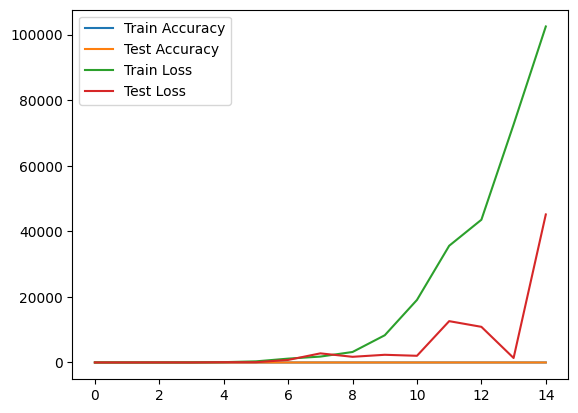

In [11]:
num_classes = 5
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Number of classes
])

def preprocess(img, label):
    img = tf.image.resize(img, (224, 224))  # Größe anpassen
    img = img / 255.0  # Normalisierung
    return img, tf.one_hot(label, num_classes)  # One-Hot-Encoding der Labels

batch_size = 32
train_dataset = (
    train_dataset
        .map(preprocess)
        .shuffle(1000)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)

test_dataset = (
    test_dataset
        .map(preprocess)
        .batch(batch_size)
        .prefetch(tf.data.AUTOTUNE)
)


model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=15,
    verbose=1
)

model.save_weights(os.path.join(model_folder, weights_filename))
model.save(os.path.join(model_folder, model_filename)) 

# Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.legend()

# Plot Loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.legend()
plt.show()


# Performancetest des Modells

In [12]:
model = load_model(os.path.join(model_folder, model_filename))
print("Model loaded successfully!")

# Step 2: Define Class Labels
# Ensure these match the class labels used during training
class_labels = {
    0: "Chihuahua",
    1: "Maltese Dog",
    2: "Komondor",
    3: "German Shepherd",
    4: "African Hunting Dog"
}
print("Class labels:", class_labels)

# Step 3: Define Image Preprocessing Function
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess an image for prediction.
    Args:
        image_path (str): Path to the image file.
        target_size (tuple): Desired image size (height, width).
    Returns:
        np.array: Preprocessed image ready for prediction.
    """
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img)  # Convert image to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values to [0, 1]
    return img_array

# Step 4: Predict Function
def predict_image(image_path):
    """
    Predict the class of an image.
    Args:
        image_path (str): Path to the image file.
    """
    preprocessed_image = preprocess_image(image_path)
    predictions = model.predict(preprocessed_image)
    predicted_class = np.argmax(predictions, axis=-1)[0]
    predicted_label = class_labels[predicted_class]

    # Display the image with its prediction
    img = load_img(image_path)
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()
    print(f"Predicted Label: {predicted_label}")

# Step 5: Test the Model with Example Images
# Update this with the path to your test image directory


for img in train_dataset:
    print(f"Testing image: {img}")
    predict_image(img)


Model loaded successfully!
Class labels: {0: 'Chihuahua', 1: 'Maltese Dog', 2: 'Komondor', 3: 'German Shepherd', 4: 'African Hunting Dog'}
Testing image: (<tf.Tensor: shape=(32, 224, 224, 3), dtype=float32, numpy=
array([[[[0.10411289, 0.1276423 , 0.11979917],
         [0.08262555, 0.11791967, 0.10615496],
         [0.13215537, 0.16744949, 0.15568478],
         ...,
         [0.3437148 , 0.34869796, 0.45615727],
         [0.5027048 , 0.531276  , 0.62177986],
         [0.41895768, 0.4747    , 0.54920983]],

        [[0.09992997, 0.12345938, 0.11162464],
         [0.10658263, 0.14187674, 0.12612045],
         [0.14940853, 0.18470265, 0.17279537],
         ...,
         [0.33974612, 0.3438777 , 0.44384146],
         [0.39399886, 0.41857845, 0.50537217],
         [0.35783088, 0.40958163, 0.48245198]],

        [[0.07447604, 0.09800545, 0.08231918],
         [0.09268332, 0.12797745, 0.1083696 ],
         [0.10796067, 0.14325479, 0.13120998],
         ...,
         [0.32738394, 0.32124886, 0

2024-12-10 11:08:16.485613: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 19268224 bytes after encountering the first element of size 19268224 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


TypeError: path should be path-like or io.BytesIO, not <class 'tuple'>